In [1]:
!pip install qiskit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 1.4 MB/s eta 0:00:00


In [2]:
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 33.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [4]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [5]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit_aer import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
class QuantumCircuit:
    """
    This class provides a simple interface for interaction
    with the quantum circuit
    """

    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)

        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')

        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)

        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()

        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)

        return np.array([expectation])

In [7]:
simulator = Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.48


<ipython-input-6-6a3097f83179>:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

In [ ]:
pip install pylatexenc

In [ ]:
pip install qiskit matplotlib pillow


In [10]:
from qiskit.visualization import circuit_drawer
from PIL import Image

# Define your backend and create your QuantumCircuit
simulator = Aer.get_backend('qasm_simulator')
circuit = QuantumCircuit(1, simulator, 100)

# Draw the circuit (using 'text' output format)
circuit_text = circuit_drawer(circuit._circuit, output='text')

# Print the circuit text
print(circuit_text)


        ┌───┐ ░ ┌───────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0 


In [8]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result

    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())

        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift

        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [36]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.263))]) # transform images to tensors/vectors

In [9]:
import torchvision
from torchvision.transforms import ToTensor
transform = ToTensor()
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)

labels = cifar_trainset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0)[0] # filter on aeroplanes
idx2 = np.where(labels == 1)[0] # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=200

# concatenate the data indices
idx = np.concatenate((idx1[:n], idx2[:n]))

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx]
cifar_trainset.data = cifar_trainset.data[idx]

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 46621462.64it/s]


Extracting ./data1/cifar-10-python.tar.gz to ./data1


In [10]:
len(cifar_trainset)

400

In [11]:
# Define a set to store unique class labels
unique_classes = set()

# Iterate over the trainset and collect unique class labels
for _, label in cifar_trainset:
    unique_classes.add(label)

# Print the unique class labels
print("Classes present in trainset:")
for class_label in sorted(unique_classes):
    print(class_label)

Classes present in trainset:
0
1


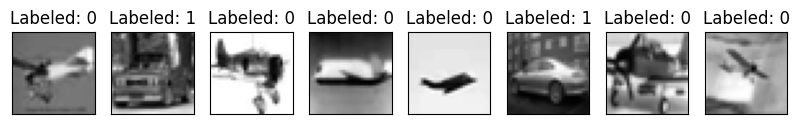

In [54]:
import numpy as np
import matplotlib.pyplot as plt

n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))

    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

In [12]:
import torchvision

cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels = cifar_testset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0)[0] # filter on aeroplanes
idx2 = np.where(labels == 1)[0] # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=40

# concatenate the data indices
idx = np.concatenate((idx1[:n], idx2[:n]))

# create the filtered dataset for our training set
cifar_testset.targets = labels[idx]
cifar_testset.data = cifar_testset.data[idx]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=True)

Files already downloaded and verified


In [13]:
len(cifar_testset)

80

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

<ipython-input-6-6a3097f83179>:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)
<ipython-input-8-625640256c98>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  result = torch.tensor([expectation_z])


Training [7%]	Loss: -0.5251
Training [13%]	Loss: -0.6440
Training [20%]	Loss: -0.7295
Training [27%]	Loss: -0.7369
Training [33%]	Loss: -0.7744
Training [40%]	Loss: -0.7980
Training [47%]	Loss: -0.7855
Training [53%]	Loss: -0.8078
Training [60%]	Loss: -0.8171
Training [67%]	Loss: -0.8203
Training [73%]	Loss: -0.8318
Training [80%]	Loss: -0.8238
Training [87%]	Loss: -0.8437
Training [93%]	Loss: -0.8291
Training [100%]	Loss: -0.8405


Text(0, 0.5, 'Neg Log Likelihood Loss')

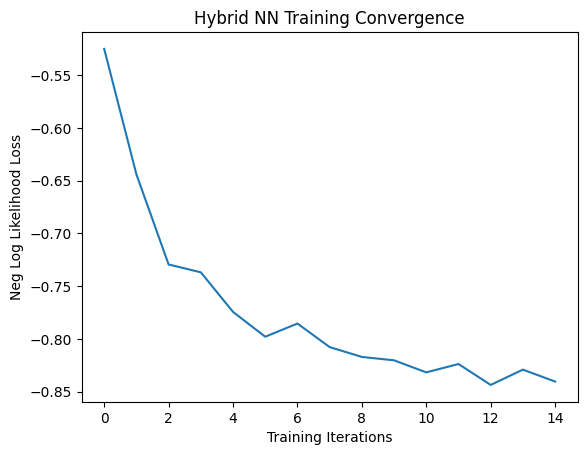

In [15]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 15
loss_list2 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list2.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list2[-1]))

#Alongside, let's also plot the data
plt.plot(loss_list2)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 80 test images: {100 * correct // total} %')

<ipython-input-11-6a3097f83179>:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Accuracy of the network on the 10000 test images: 81 %


In [61]:
desired_classes = ['airplane', 'car']

In [24]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in desired_classes}
total_pred = {classname: 0 for classname in desired_classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # labels = labels.to(device)
        # images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[desired_classes[label]] += 1
            total_pred[desired_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

<ipython-input-11-6a3097f83179>:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Accuracy for class: airplane is 87.0 %
Accuracy for class: car   is 84.0 %


In [33]:
import torchvision
import torch
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import numpy as np

# Define class mapping dictionary
class_mapping = {
    0: 8,
    1: 7,
    3: 0,  # Mapping "cat" to label 0
    5: 1,   # Mapping "dog" to label 1
}
transform = ToTensor()
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)

# Access image data and labels
labels = cifar_trainset.targets

# Update labels based on class mapping
for i in range(len(labels)):
    labels[i] = class_mapping.get(labels[i], labels[i])

# Convert labels to numpy array for filtering
labels = np.array(labels)

# Filter indices for cats and dogs
idx1 = np.where(labels == 0)[0] # filter on cats
idx2 = np.where(labels == 1)[0] # filter on dogs

# Specify number of datapoints per class (i.e. there will be n pictures of cats and n pictures of dogs in the training set)
n = 200

# concatenate the data indices
idx = np.concatenate((idx1[:n], idx2[:n]))

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx]
cifar_trainset.data = cifar_trainset.data[idx]

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)


Files already downloaded and verified


In [34]:
# Define a set to store unique class labels
unique_classes = set()

# Iterate over the trainset and collect unique class labels
for _, label in cifar_trainset:
    unique_classes.add(label)

# Print the unique class labels
print("Classes present in trainset:")
for class_label in sorted(unique_classes):
    print(class_label)

Classes present in trainset:
0
1


In [35]:
len(cifar_trainset)

400

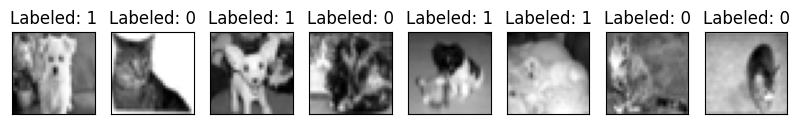

In [17]:
import numpy as np
import matplotlib.pyplot as plt

n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))

    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

In [36]:
import torchvision

# Define class mapping dictionary
class_mapping = {
    0: 8,
    1: 7,
    3: 0,  # Mapping "cat" to label 0
    5: 1,   # Mapping "dog" to label 1
}

transform = ToTensor()
cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels = cifar_testset.targets # get the labels for the data

# Update labels based on class mapping
for i in range(len(labels)):
    labels[i] = class_mapping.get(labels[i], labels[i])


labels = np.array(labels)

idx1 = np.where(labels == 0)[0] # filter on cats
idx2 = np.where(labels == 1)[0] # filter on dogs

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=40

# concatenate the data indices
idx = np.concatenate((idx1[:n], idx2[:n]))

# create the filtered dataset for our training set
cifar_testset.targets = labels[idx]
cifar_testset.data = cifar_testset.data[idx]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=True)

Files already downloaded and verified


In [37]:
len(cifar_testset)

80

In [38]:
# Define a set to store unique class labels
unique_classes = set()

# Iterate over the trainset and collect unique class labels
for _, label in cifar_testset:
    unique_classes.add(label)

# Print the unique class labels
print("Classes present in testset:")
for class_label in sorted(unique_classes):
    print(class_label)

Classes present in testset:
0
1


<ipython-input-6-6a3097f83179>:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)
<ipython-input-11-625640256c98>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  result = torch.tensor([expectation_z])


Training [7%]	Loss: -0.4921
Training [13%]	Loss: -0.5040
Training [20%]	Loss: -0.4838
Training [27%]	Loss: -0.4973
Training [33%]	Loss: -0.5123
Training [40%]	Loss: -0.4868
Training [47%]	Loss: -0.4976
Training [53%]	Loss: -0.4938
Training [60%]	Loss: -0.4815
Training [67%]	Loss: -0.4834
Training [73%]	Loss: -0.4948
Training [80%]	Loss: -0.4797
Training [87%]	Loss: -0.4929
Training [93%]	Loss: -0.5129
Training [100%]	Loss: -0.5248


Text(0, 0.5, 'Neg Log Likelihood Loss')

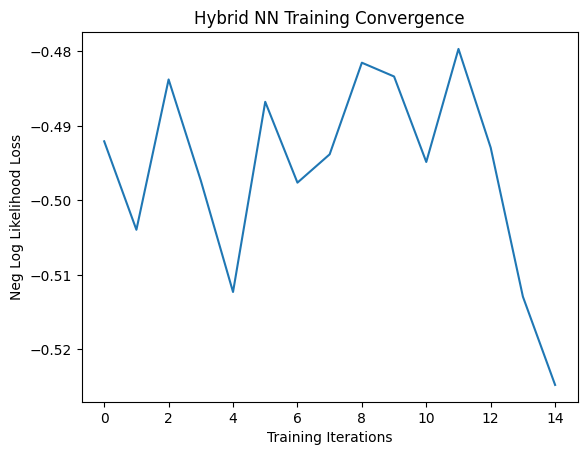

In [21]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 15
loss_list2 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list2.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list2[-1]))

#Alongside, let's also plot the data
plt.plot(loss_list2)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 80 test images: {100 * correct // total} %')

<ipython-input-6-6a3097f83179>:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Accuracy of the network on the 80 test images: 52 %


In [23]:
desired_classes = ['cat', 'dog']

In [24]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in desired_classes}
total_pred = {classname: 0 for classname in desired_classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # labels = labels.to(device)
        # images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[desired_classes[label]] += 1
            total_pred[desired_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

<ipython-input-6-6a3097f83179>:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Accuracy for class: cat   is 37.5 %
Accuracy for class: dog   is 67.5 %


In [18]:
import torchvision
import torch
import torchvision.datasets as datasets
import numpy as np

# Define class mapping dictionary
class_mapping = {
    0: 6,
    1: 7,
    8: 0,  # Mapping "ship" to label 0
    9: 1,   # Mapping "truck" to label 1
}

cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)

# Access image data and labels
labels = cifar_trainset.targets

# Update labels based on class mapping
for i in range(len(labels)):
    labels[i] = class_mapping.get(labels[i], labels[i])

# Convert labels to numpy array for filtering
labels = np.array(labels)

# Filter indices for cats and dogs
idx1 = np.where(labels == 0)[0] # filter on ships
idx2 = np.where(labels == 1)[0] # filter on trucks

# Specify number of datapoints per class (i.e. there will be n pictures of cats and n pictures of dogs in the training set)
n = 200

# concatenate the data indices
idx = np.concatenate((idx1[:n], idx2[:n]))

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx]
cifar_trainset.data = cifar_trainset.data[idx]

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)

Files already downloaded and verified


In [19]:
# Define a set to store unique class labels
unique_classes = set()

# Iterate over the trainset and collect unique class labels
for _, label in cifar_trainset:
    unique_classes.add(label)

# Print the unique class labels
print("Classes present in trainset:")
for class_label in sorted(unique_classes):
    print(class_label)

Classes present in trainset:
0
1


In [20]:
len(cifar_trainset)

400

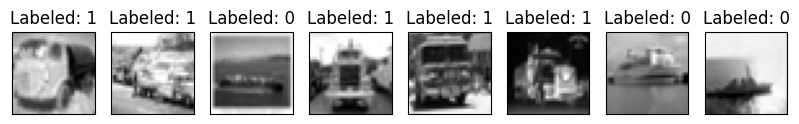

In [22]:
import numpy as np
import matplotlib.pyplot as plt

n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))

    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

In [21]:
import torchvision

# Define class mapping dictionary
class_mapping = {
    0: 6,
    1: 7,
    8: 0,  # Mapping "cat" to label 0
    9: 1,   # Mapping "dog" to label 1
}


cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels = cifar_testset.targets # get the labels for the data

# Update labels based on class mapping
for i in range(len(labels)):
    labels[i] = class_mapping.get(labels[i], labels[i])


labels = np.array(labels)

idx1 = np.where(labels == 0)[0] # filter on cats
idx2 = np.where(labels == 1)[0] # filter on dogs

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=40

# concatenate the data indices
idx = np.concatenate((idx1[:n], idx2[:n]))

# create the filtered dataset for our training set
cifar_testset.targets = labels[idx]
cifar_testset.data = cifar_testset.data[idx]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=True)

Files already downloaded and verified


In [22]:
len(cifar_testset)

80

In [23]:
# Define a set to store unique class labels
unique_classes = set()

# Iterate over the trainset and collect unique class labels
for _, label in cifar_testset:
    unique_classes.add(label)

# Print the unique class labels
print("Classes present in testset:")
for class_label in sorted(unique_classes):
    print(class_label)

Classes present in testset:
0
1


<ipython-input-6-6a3097f83179>:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Training [7%]	Loss: -0.5018
Training [13%]	Loss: -0.4908
Training [20%]	Loss: -0.5708
Training [27%]	Loss: -0.5702
Training [33%]	Loss: -0.6520
Training [40%]	Loss: -0.6543
Training [47%]	Loss: -0.7155
Training [53%]	Loss: -0.7026
Training [60%]	Loss: -0.7275
Training [67%]	Loss: -0.6974
Training [73%]	Loss: -0.5639
Training [80%]	Loss: -0.5391
Training [87%]	Loss: -0.5356
Training [93%]	Loss: -0.6851
Training [100%]	Loss: -0.7460


Text(0, 0.5, 'Neg Log Likelihood Loss')

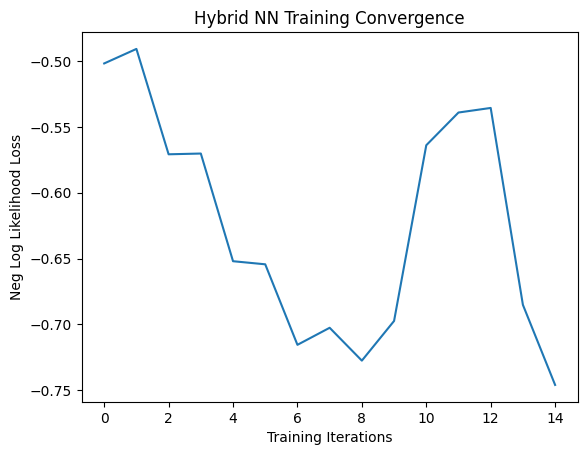

In [29]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 15
loss_list2 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list2.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list2[-1]))

#Alongside, let's also plot the data
plt.plot(loss_list2)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [30]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 80 test images: {100 * correct // total} %')

<ipython-input-6-6a3097f83179>:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Accuracy of the network on the 80 test images: 83 %


In [32]:
desired_classes = ['ship', 'truck']

In [31]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in desired_classes}
total_pred = {classname: 0 for classname in desired_classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # labels = labels.to(device)
        # images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[desired_classes[label]] += 1
            total_pred[desired_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

<ipython-input-6-6a3097f83179>:30: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Accuracy for class: ship  is 85.0 %
Accuracy for class: truck is 92.5 %
